In [1]:
from dataclasses import asdict

import math
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from minitorch.module import Network, Linear
from minitorch.optim import SGDOptimizer
from minitorch.datasets import Datasets, DatasetTypes
from minitorch.operators import sigmoid

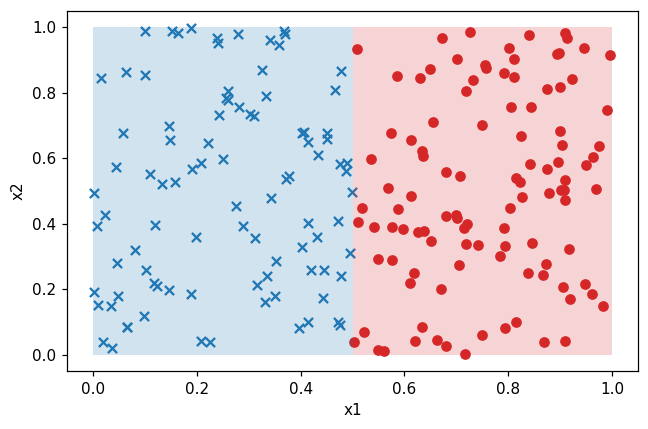

In [2]:
# Create a dataset
dataset_type = DatasetTypes.simple

datasets = Datasets.generate_datasets(n_samples=200)
dataset = asdict(datasets)[dataset_type]

pos_class = [x for (x, y) in zip(dataset.xs, dataset.ys) if y == 1]
neg_class = [x for (x, y) in zip(dataset.xs, dataset.ys) if y == 0]

x1_pos, x2_pos = zip(*pos_class)
x1_neg, x2_neg = zip(*neg_class)

fig, ax = plt.subplots(1, 1, dpi=110)
ax.scatter(list(x1_pos), list(x2_pos), marker="x", c="tab:blue")
ax.scatter(list(x1_neg), list(x2_neg), marker="o", c="tab:red")

left = Rectangle((0, 0), 0.5, 1.0, color="tab:blue", alpha=0.2, lw=0.0)
right = Rectangle((0.5, 0), 0.5, 1.0, color="tab:red", alpha=0.2, lw=0.0)
ax.add_patch(left)
ax.add_patch(right)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

fig.tight_layout();

In [3]:
# Create a linear network
linear = Linear(input_dim=2, output_dim=1)

In [4]:
# Define an optimizer
optimizer = SGDOptimizer(parameters=linear.parameters(), lr=0.75)

In [5]:
# Data
X = [list(x) for x in dataset.xs]
y_true = dataset.ys

In [6]:
# Training loop
n_epochs = 200
losses = []

for epoch in range(n_epochs): 
    
    # Zero all grads
    optimizer.zero_grad()
    
    # Forward
    y_hat = linear.forward(X)
    
    # Apply nonlinearity 
    # y_hat = [[scalar.relu() for scalar in row] for row in y_hat]

    # Convert to binary class probabilties
    y_hat = [[scalar.sigmoid() for scalar in row] for row in y_hat]

    # Compute a loss
    loss_per_epoch = 0
    for i in range(len(y_true)):
        loss_per_epoch += (y_hat[i][0].log() if y_true[i] == 1.0 else (- y_hat[i][0] + 1).log())
    loss_per_epoch = (- loss_per_epoch / len(y_true))
    loss_per_epoch.backward()
    
    optimizer.step()
    
    # Record
    losses.append(loss_per_epoch.data)
    if epoch % 10 == 0:
        print(f"epoch {epoch}: loss = {loss_per_epoch.data}")

epoch 0: loss = 0.578813107575419
epoch 10: loss = 0.5146110123442732
epoch 20: loss = 0.46775032983798676
epoch 30: loss = 0.4302287897045026
epoch 40: loss = 0.3996767499122002
epoch 50: loss = 0.3743973085210134
epoch 60: loss = 0.35316802364708305
epoch 70: loss = 0.3350991637388009
epoch 80: loss = 0.3195343361416823
epoch 90: loss = 0.30598211628916355
epoch 100: loss = 0.2940691077345281
epoch 110: loss = 0.28350751340732666
epoch 120: loss = 0.27407249560404606
epoch 130: loss = 0.26558617111216276
epoch 140: loss = 0.25790614583076504
epoch 150: loss = 0.25091719109085747
epoch 160: loss = 0.24452512159812423
epoch 170: loss = 0.2386522360043474
epoch 180: loss = 0.23323388063609826
epoch 190: loss = 0.22821583043619112


In [7]:
y_hat = linear.forward(X)
y_hat = [[scalar.sigmoid() for scalar in row] for row in y_hat]
y_hat_classes = [[1 if proba.data >= 0.5 else 0 for proba in row] for row in y_hat]
y_hat_classes = list(itertools.chain.from_iterable(y_hat_classes))

In [8]:
# Accuraccy
sum(
    [
        1 if y_hat_c == y_true_c 
        else 0 for (y_hat_c, y_true_c) in zip(y_hat_classes, y_true)
    ]
) / len(y_true)

0.97

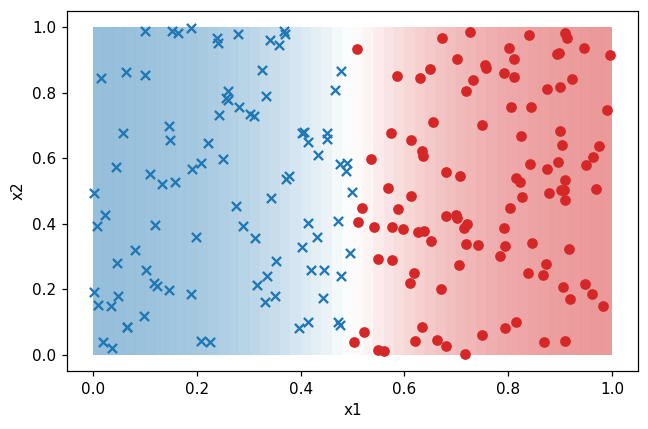

In [9]:
# Visualising predictions
fig, ax = plt.subplots(1, 1, dpi=110)
ax.scatter(list(x1_pos), list(x2_pos), marker="x", c="tab:blue")
ax.scatter(list(x1_neg), list(x2_neg), marker="o", c="tab:red")

# Visualise classification function

x1_positions = list(np.linspace(0, 1, 51))

for x1_lower, x1_upper in zip(x1_positions, x1_positions[1:]):
    
    # Create corresponding x2 values for lower
    X_lower = [list((x1_lower, i/10)) for i in range(11)]
    y_lower = linear.forward(X_lower)
    y_mean_lower = sigmoid(sum(scalar[0].data for scalar in y_lower) / len(y_lower))

    # Create corresponding x2 values for upper
    X_upper = [list((x1_upper, i/10)) for i in range(11)]
    y_upper = linear.forward(X_upper)
    y_mean_upper = sigmoid(sum(scalar[0].data for scalar in y_upper) / len(y_upper))

    # Plot and fill    
    ax.fill_betweenx(
        [i/10 for i in range(11)],
        [x1_upper for _ in range(11)],
        x1_lower,
        alpha=(y_mean_lower - 0.5) if y_mean_lower >= 0.5 else (0.5 - y_mean_lower),
        color="tab:blue" if y_mean_lower >= 0.5 else "tab:red",
        lw=0.01
    )

ax.set_xlabel("x1")
ax.set_ylabel("x2")

fig.tight_layout();